In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import datetime
import os

from utils.pinn import *
import utils.data_generator as dg
import utils.sample_plan as sp

# Lotka-Voltera 2 populations - Holling 1

## Sampled data

In [12]:
from utils.models_catalogue import lv_model_2pop_derivatives, eco_to_dimless_2pop

# Parameters of the simulation
t_max = 100
nb_point = 60
data_noise_intensity = 0.08
noise_seed = 111

# Parameters of the dynamics
Tref = 10
eco_params_2pop = {"a1": 0.088, "a2": 0.020, "e": 1, "c": 0.96, "K": 0.034, "S": 0.12, "xR1": 0.12, "xR2": 0.91, 
                   "b":1/0.12, "Tref": Tref, "func_resp": "holling1", "a": 0.086} # b = e/S
dimless_params_2pop = eco_to_dimless_2pop(eco_params_2pop, func_resp=eco_params_2pop["func_resp"])
dimless_params_2pop["func_resp"], dimless_params_2pop["Tref"] = eco_params_2pop["func_resp"], Tref
X_ini = [1, 1] # Predator, Prey


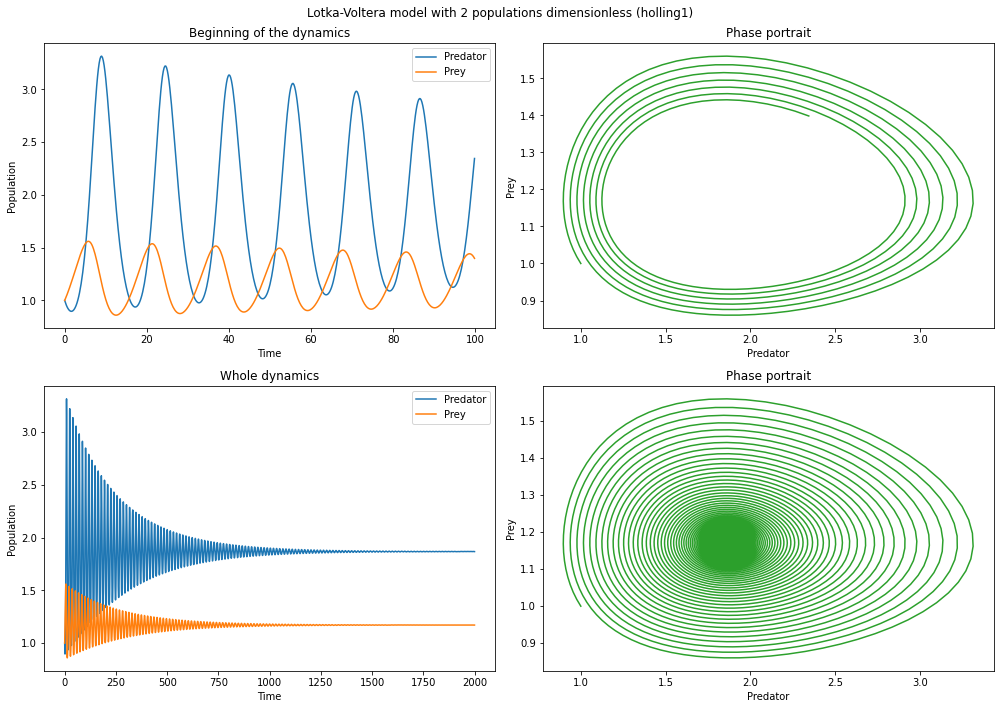

In [13]:
# Plot the dynamics
t_simu = np.linspace(0, 2000, 10000)
X_simu = odeint(lv_model_2pop_derivatives, X_ini, t_simu, args=(dimless_params_2pop, ), atol=1e-8, rtol=1e-11)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
idx_max = 500
axs[0, 0].plot(t_simu[:idx_max], X_simu[:idx_max])
axs[0, 0].set_xlabel("Time") ; axs[0, 0].set_ylabel("Population")
axs[0, 0].set_title("Beginning of the dynamics")
axs[0, 0].legend(["Predator", "Prey"])
axs[0, 1].plot(X_simu[:idx_max, 0], X_simu[:idx_max, 1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
axs[0, 1].set_xlabel("Predator")
axs[0, 1].set_ylabel("Prey")
axs[0, 1].set_title("Phase portrait")
axs[1, 0].plot(t_simu, X_simu)
axs[1, 0].set_xlabel("Time")
axs[1, 0].set_ylabel("Population")
axs[1, 0].set_title("Whole dynamics")
axs[1, 0].legend(["Predator", "Prey"])
axs[1, 1].plot(X_simu[:, 0], X_simu[:, 1], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
axs[1, 1].set_xlabel("Predator")
axs[1, 1].set_ylabel("Prey")
axs[1, 1].set_title("Phase portrait")

plt.suptitle("Lotka-Voltera model with 2 populations dimensionless ("+dimless_params_2pop["func_resp"]+")")
plt.tight_layout()
plt.show()

* * * * Sampled data * * * *
Number of points: 60
Noise intensity: 0.08


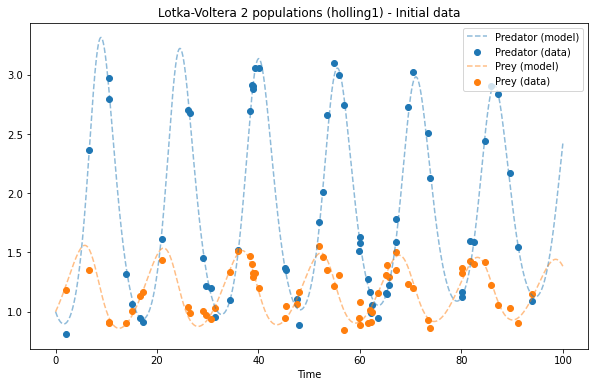

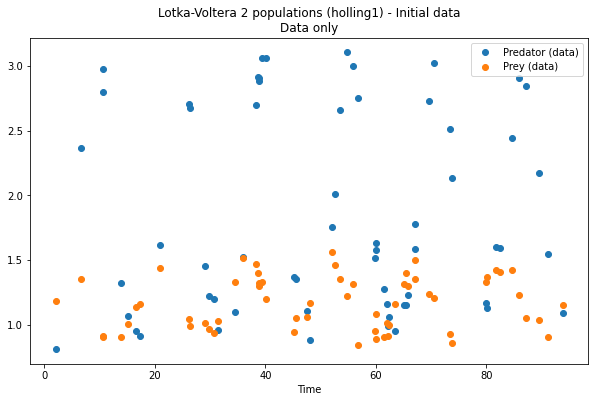

In [14]:
# Data generation
datagen_LV2 = dg.data_generator(lv_model_2pop_derivatives, dimless_params_2pop, t_max, X_ini, labels_states=["Predator", "Prey"], 
                                model_name=f"Lotka-Voltera 2 populations ({dimless_params_2pop['func_resp']})")
sample_plan_LV2 = sp.sample_plan(tmax=t_max, nbpoint=nb_point, plan_type="random")
print("* * * * Sampled data * * * *")
print("Number of points:", nb_point)
print("Noise intensity:", data_noise_intensity)
plt.figure(figsize=(10, 6))
datagen_LV2.get_data(plan=sample_plan_LV2, noise_intensity=data_noise_intensity, noise_seed=noise_seed, 
                       plot_data=True, permissible_range=[0, np.inf], default_value=0)
plt.show()
plt.figure(figsize=(10, 6))
datagen_LV2.plot_initial_data(elements_to_plot=["data"], title=datagen_LV2.model_name+" - Initial data"+"\nData only")

In [15]:
fitted_params = ['kappa_tild', 'Tr1_tild', 'Tr2_tild', 'Tc_tild', 'Ta_tild', 'lambda_tild']
# fitted_params = ['Tr1_tild', 'Tr2_tild']
dimless_params_2pop_fitted = {key: value * (1+np.random.normal(0, 0.3)) \
                              for key, value in dimless_params_2pop.items() if key in fitted_params}
dimless_params_2pop_fixed = {key: value for key, value in dimless_params_2pop.items() if key not in fitted_params}


from tabulate import tabulate
table = []
for key in dimless_params_2pop.keys():
    real_value = dimless_params_2pop.get(key, "-")
    initial_value = dimless_params_2pop_fitted.get(key, "-")
    table.append([key, "{:.3f}".format(real_value) if isinstance(real_value, float) else real_value, 
                  "{:.3f}".format(initial_value) if isinstance(initial_value, float) else initial_value])
print(tabulate(table, headers=["Parameter", "Real Value", "Initial Fitted Value"], tablefmt="grid"))


+-------------+--------------+------------------------+
| Parameter   | Real Value   | Initial Fitted Value   |
+=============+==============+========================+
| kappa_tild  | 0.031        | 0.007                  |
+-------------+--------------+------------------------+
| Tr1_tild    | 11.364       | 13.586                 |
+-------------+--------------+------------------------+
| Tr2_tild    | 50.000       | 34.527                 |
+-------------+--------------+------------------------+
| Tc_tild     | 13.310       | 13.321                 |
+-------------+--------------+------------------------+
| Ta_tild     | 96.899       | 132.526                |
+-------------+--------------+------------------------+
| lambda_tild | 0.652        | 0.661                  |
+-------------+--------------+------------------------+
| func_resp   | holling1     | -                      |
+-------------+--------------+------------------------+
| Tref        | 10           | -                

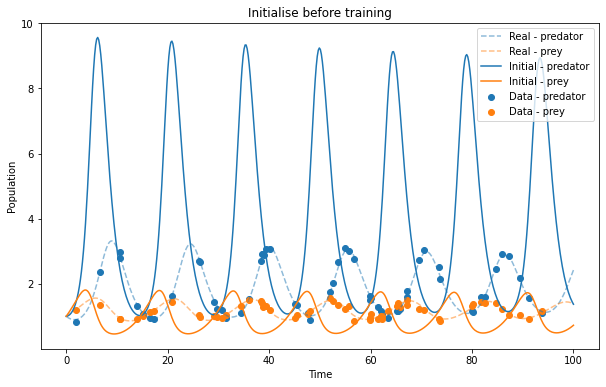

In [16]:
# Plot the dynamics
t_simu_adapt = np.linspace(0, t_max, 500)
X_simu_real = odeint(lv_model_2pop_derivatives, X_ini, t_simu_adapt, args=(dimless_params_2pop, ), atol=1e-8, rtol=1e-11)
dimless_params_2pop_ini = {**dimless_params_2pop_fixed, **dimless_params_2pop_fitted}
X_simu_ini = odeint(lv_model_2pop_derivatives, X_ini, t_simu_adapt, args=(dimless_params_2pop_ini, ), atol=1e-8, rtol=1e-11)



defaut_color = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(10, 6))
plt.plot(t_simu_adapt, X_simu_real[:, 0], label="Real - predator", color=defaut_color[0], linestyle="--", alpha=0.5)
plt.plot(t_simu_adapt, X_simu_real[:, 1], label="Real - prey", color=defaut_color[1], linestyle="--", alpha=0.5)
plt.plot(t_simu_adapt, X_simu_ini[:, 0], label="Initial - predator", color=defaut_color[0])
plt.plot(t_simu_adapt, X_simu_ini[:, 1], label="Initial - prey", color=defaut_color[1])
plt.scatter(datagen_LV2.t_samples[0], datagen_LV2.states_data_noisy[0], color=defaut_color[0], label="Data - predator")
plt.scatter(datagen_LV2.t_samples[1], datagen_LV2.states_data_noisy[1], color=defaut_color[1], label="Data - prey")
plt.xlabel("Time") ; plt.ylabel("Population")
plt.title("Initialise before training")
plt.legend()
plt.show()

## Loop on number of layers

In [17]:
list_lr = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]

nbr_hidden_layers = 3
nbr_neur_in_hidden_layers = 128
niter_weights=[25000]
weights = [[5, 5, 0.5, 0.5, 10, 10]] # [[PDE, BC, Data]]

directory_path = "outputs/learning_rate/" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "-loop_lr_LV2-all_params"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory created at: {directory_path}")
else:
    print(f"Directory already exists at: {directory_path}")

all_models_lr = []
all_perf_lr = []
for k in range(len(list_lr)):
    lr = list_lr[k]
    nn_architecture = [1] + [nbr_neur_in_hidden_layers] * nbr_hidden_layers + [2]
    print( "\n\n     # # # # # # # # # # # # # # # # # # # # # ")
    print(f" # # # # # Learning rate: {lr} # # # # #")
    print( "     # # # # # # # # # # # # # # # # # # # # # \n")
    path_for_export = os.path.join(directory_path, str(k).zfill(2)+'_lr'+str(lr))
    print(f"Path for export: {path_for_export}")

    # Adjust the PINN
    model_pinn_LV2_test = pinn(lv_model_2pop_derivatives, datagen_LV2, dimless_params_2pop_fitted, dimless_params_2pop_fixed)
    model_pinn_LV2_test.get_train_data()
    model_pinn_LV2_test.compile_train_model(lr=lr, nnlayers = nn_architecture, activation_function="swish", initcond="Glorot normal",
                                            weights=weights, niter_weights=niter_weights, file_var_export=path_for_export+"-loss_hist_train.dat")
    # Plot the training
    model_pinn_LV2_test.basic_plot(elements_to_plot={"simulation":[0, 1], "data":[0, 1], "prediction":[0, 1]}, file_save_fig=path_for_export+"-prediction_PINN.jpg")
    model_pinn_LV2_test.plot_convergence(file_save_fig=path_for_export+"-param_convergence.jpg")
    model_pinn_LV2_test.plot_predicted_dynamic(elements_to_plot={"simulation":[0,1], "data":[0,1], "prediction":[0,1]}, 
                                               file_save_fig=path_for_export+"-prediction_with_params.jpg", nb_p_t=10000)
    model_pinn_LV2_test.plot_loss_history(file_save_fig=path_for_export+"-loss_history.jpg", elements_to_plot=["loss_train"], 
                                          start_step_idx=2, labels_loss = ["PDE", "Boundary conditions",  "Data"])
    model_pinn_LV2_test.gif_evolution(elements_to_plot={"simulation":[0,1], "data":[0,1], "prediction":[0,1]}, 
                                      file_save_gif=path_for_export+'-gif_training.gif', nb_p_t=2000, max_gif_duration_in_sec=5)
    plt.close('all')
    all_perf_lr.append(model_pinn_LV2_test.performance())
    print("Performance of the model with a learning rate of " + str(lr) + ":", all_perf_lr[-1])
    model_pinn_LV2_test.save_possible_attr(filename_save=path_for_export+"-0_model_data.pkl")
    all_models_lr.append(model_pinn_LV2_test)
with open(os.path.join(directory_path, "all_performances.pkl"), 'wb') as f:
    pickle.dump(all_perf_lr, f)
# with open(os.path.join(directory_path, "all_performances.pkl"), 'rb') as f:
#     all_perf_lr_import = pickle.load(f)

Directory created at: outputs/learning_rate/20240304_004520-loop_lr_LV2-all_params


     # # # # # # # # # # # # # # # # # # # # # 
 # # # # # Learning rate: 1e-05 # # # # #
     # # # # # # # # # # # # # # # # # # # # # 

Path for export: outputs/learning_rate/20240304_004520-loop_lr_LV2-all_params\00_lr1e-05
- - - - Train the PINN - - - -
Fitted parameters:  kappa_tild ; Tr1_tild ; Tr2_tild ; Tc_tild ; Ta_tild ; lambda_tild
Fixed parameters:  func_resp ; Tref
Learning rate:  1e-05
Architecture:  [1, 128, 128, 128, 2] 


* * * * Part 1 of the training * * * *
Compiling model...
Building feed-forward neural network...


c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.442262 s

'compile' took 2.861929 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.74e-01, 2.37e+00, 3.56e-01, 8.44e-01, 4.34e+01, 1.29e+02]    [4.74e-01, 2.37e+00, 3.56e-01, 8.44e-01, 4.34e+01, 1.29e+02]    []  
1000      [2.12e-01, 1.05e-01, 1.54e-01, 4.99e-01, 6.68e+00, 1.02e+00]    [2.12e-01, 1.05e-01, 1.54e-01, 4.99e-01, 6.68e+00, 1.02e+00]    []  
2000      [1.18e-01, 1.14e-01, 3.57e-02, 2.48e-01, 5.79e+00, 5.82e-01]    [1.18e-01, 1.14e-01, 3.57e-02, 2.48e-01, 5.79e+00, 5.82e-01]    []  
3000      [1.12e-01, 1.15e-01, 6.74e-04, 1.05e-01, 5.53e+00, 5.11e-01]    [1.12e-01, 1.15e-01, 6.74e-04, 1.05e-01, 5.53e+00, 5.11e-01]    []  
4000      [1.14e-01, 1.12e-01, 6.79e-03, 3.41e-02, 5.33e+00, 4.80e-01]    [1.14e-01, 1.12e-01, 6.79e-03, 3.41e-02, 5.33e+00, 4.80e-01]    []  
5000      [1.07e-01, 1.06e-01, 1.40e-02, 7.52e-03, 5.17e+00, 4.6

c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.436414 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.79e+01, 1.53e+01, 3.44e-01, 8.02e-01, 2.98e+01, 6.33e+02]    [3.79e+01, 1.53e+01, 3.44e-01, 8.02e-01, 2.98e+01, 6.33e+02]    []  
1000      [1.09e-01, 1.23e-01, 1.63e-03, 9.61e-02, 5.59e+00, 5.14e-01]    [1.09e-01, 1.23e-01, 1.63e-03, 9.61e-02, 5.59e+00, 5.14e-01]    []  
2000      [1.07e-01, 1.23e-01, 2.49e-02, 6.84e-03, 5.20e+00, 4.65e-01]    [1.07e-01, 1.23e-01, 2.49e-02, 6.84e-03, 5.20e+00, 4.65e-01]    []  
3000      [8.75e-02, 1.19e-01, 6.72e-04, 1.88e-04, 4.89e+00, 4.50e-01]    [8.75e-02, 1.19e-01, 6.72e-04, 1.88e-04, 4.89e+00, 4.50e-01]    []  
4000      [8.42e-02, 1.18e-01, 9.20e-04, 2.96e-04, 4.76e+00, 4.38e-01]    [8.42e-02, 1.18e-01, 9.20e-04, 2.96e-04, 4.76e+00, 4.38e-01]    []  
5000      [7.79e-02, 1.13e-01, 4.06e-04, 8.25e-05, 4.70e+00, 4.27e-01]    [7.79e-02, 1.13

c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.492162 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.16e+02, 3.03e+00, 3.22e-01, 6.42e-01, 1.57e+02, 7.46e+01]    [1.16e+02, 3.03e+00, 3.22e-01, 6.42e-01, 1.57e+02, 7.46e+01]    []  
1000      [1.02e-01, 8.76e-02, 2.26e-02, 3.15e-03, 5.25e+00, 4.64e-01]    [1.02e-01, 8.76e-02, 2.26e-02, 3.15e-03, 5.25e+00, 4.64e-01]    []  
2000      [9.87e-02, 5.52e-02, 6.53e-04, 7.77e-04, 4.77e+00, 4.40e-01]    [9.87e-02, 5.52e-02, 6.53e-04, 7.77e-04, 4.77e+00, 4.40e-01]    []  
3000      [8.32e-02, 3.16e-02, 1.41e-04, 7.11e-05, 4.70e+00, 4.24e-01]    [8.32e-02, 3.16e-02, 1.41e-04, 7.11e-05, 4.70e+00, 4.24e-01]    []  
4000      [6.65e-02, 1.49e-02, 3.51e-06, 4.53e-06, 4.67e+00, 4.07e-01]    [6.65e-02, 1.49e-02, 3.51e-06, 4.53e-06, 4.67e+00, 4.07e-01]    []  
5000      [5.82e-02, 6.86e-03, 1.01e-06, 1.44e-05, 4.50e+00, 3.80e-01]    [5.82e-02, 6.86

c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.534692 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [5.49e+03, 5.93e+00, 3.22e-01, 8.37e-01, 8.66e+01, 6.83e+02]    [5.49e+03, 5.93e+00, 3.22e-01, 8.37e-01, 8.66e+01, 6.83e+02]    []  
1000      [1.05e-01, 1.10e-01, 3.04e-04, 1.03e-03, 4.75e+00, 4.64e-01]    [1.05e-01, 1.10e-01, 3.04e-04, 1.03e-03, 4.75e+00, 4.64e-01]    []  
2000      [1.29e-01, 8.62e-02, 2.54e-06, 1.16e-07, 3.33e+00, 4.00e-01]    [1.29e-01, 8.62e-02, 2.54e-06, 1.16e-07, 3.33e+00, 4.00e-01]    []  
3000      [8.41e-02, 6.55e-02, 2.36e-06, 1.65e-06, 3.01e+00, 3.57e-01]    [8.41e-02, 6.55e-02, 2.36e-06, 1.65e-06, 3.01e+00, 3.57e-01]    []  
4000      [6.71e-02, 3.51e-02, 1.81e-07, 2.15e-09, 2.85e+00, 3.21e-01]    [6.71e-02, 3.51e-02, 1.81e-07, 2.15e-09, 2.85e+00, 3.21e-01]    []  
5000      [1.20e-01, 1.24e-02, 1.19e-07, 8.65e-10, 1.52e+00, 2.63e-01]    [1.20e-01, 1.24

c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.614902 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.39e+02, 1.08e+00, 3.66e-01, 6.49e-01, 1.71e+01, 9.24e+01]    [1.39e+02, 1.08e+00, 3.66e-01, 6.49e-01, 1.71e+01, 9.24e+01]    []  
1000      [9.38e-02, 2.81e-02, 1.31e-05, 2.44e-06, 3.43e+00, 3.66e-01]    [9.38e-02, 2.81e-02, 1.31e-05, 2.44e-06, 3.43e+00, 3.66e-01]    []  
2000      [3.73e-02, 3.40e-03, 2.51e-07, 4.55e-06, 3.02e+00, 2.94e-01]    [3.73e-02, 3.40e-03, 2.51e-07, 4.55e-06, 3.02e+00, 2.94e-01]    []  
3000      [7.93e-02, 6.36e-03, 2.10e-06, 1.24e-06, 1.23e+00, 1.95e-01]    [7.93e-02, 6.36e-03, 2.10e-06, 1.24e-06, 1.23e+00, 1.95e-01]    []  
4000      [1.91e-02, 3.45e-03, 2.95e-08, 5.52e-07, 9.62e-01, 1.23e-01]    [1.91e-02, 3.45e-03, 2.95e-08, 5.52e-07, 9.62e-01, 1.23e-01]    []  
5000      [1.73e-02, 3.70e-03, 1.70e-07, 4.90e-07, 7.73e-01, 1.01e-01]    [1.73e-02, 3.70

c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.963734 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.76e+02, 1.80e-01, 2.48e-01, 7.02e-01, 1.07e+02, 3.59e+01]    [2.76e+02, 1.80e-01, 2.48e-01, 7.02e-01, 1.07e+02, 3.59e+01]    []  
1000      [1.11e-01, 1.15e-01, 2.41e-09, 1.77e-07, 3.15e+00, 3.82e-01]    [1.11e-01, 1.15e-01, 2.41e-09, 1.77e-07, 3.15e+00, 3.82e-01]    []  
2000      [9.72e-02, 8.49e-02, 2.05e-05, 2.81e-06, 2.33e+00, 3.26e-01]    [9.72e-02, 8.49e-02, 2.05e-05, 2.81e-06, 2.33e+00, 3.26e-01]    []  
3000      [3.49e-01, 5.11e-02, 3.37e-06, 2.21e-05, 1.19e+00, 1.73e-01]    [3.49e-01, 5.11e-02, 3.37e-06, 2.21e-05, 1.19e+00, 1.73e-01]    []  
4000      [9.50e-02, 2.78e-02, 1.60e-04, 3.32e-06, 1.01e+00, 1.65e-01]    [9.50e-02, 2.78e-02, 1.60e-04, 3.32e-06, 1.01e+00, 1.65e-01]    []  
5000      [2.40e-02, 8.91e-03, 4.64e-05, 8.39e-07, 7.24e-01, 1.48e-01]    [2.40e-02, 8.91

c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.662041 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.47e+01, 2.02e+01, 3.95e-01, 5.69e-01, 6.80e+01, 3.09e+02]    [4.47e+01, 2.02e+01, 3.95e-01, 5.69e-01, 6.80e+01, 3.09e+02]    []  
1000      [9.43e-02, 1.11e-01, 2.18e-05, 3.36e-05, 4.63e+00, 4.51e-01]    [9.43e-02, 1.11e-01, 2.18e-05, 3.36e-05, 4.63e+00, 4.51e-01]    []  
2000      [1.05e-01, 9.90e-02, 4.64e-08, 4.57e-08, 3.71e+00, 4.12e-01]    [1.05e-01, 9.90e-02, 4.64e-08, 4.57e-08, 3.71e+00, 4.12e-01]    []  
3000      [1.13e-01, 8.86e-02, 2.22e-04, 8.11e-04, 3.50e+00, 3.82e-01]    [1.13e-01, 8.86e-02, 2.22e-04, 8.11e-04, 3.50e+00, 3.82e-01]    []  
4000      [7.93e-02, 7.50e-02, 4.39e-04, 5.20e-06, 3.00e+00, 3.71e-01]    [7.93e-02, 7.50e-02, 4.39e-04, 5.20e-06, 3.00e+00, 3.71e-01]    []  
5000      [6.12e-02, 5.77e-02, 7.99e-05, 5.52e-06, 2.65e+00, 3.74e-01]    [6.12e-02, 5.77

c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.810334 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [6.73e+01, 1.15e-01, 2.99e-01, 6.75e-01, 1.12e+01, 6.24e+01]    [6.73e+01, 1.15e-01, 2.99e-01, 6.75e-01, 1.12e+01, 6.24e+01]    []  
1000      [1.15e-01, 5.68e-02, 8.08e-03, 7.29e-03, 3.66e+00, 3.69e-01]    [1.15e-01, 5.68e-02, 8.08e-03, 7.29e-03, 3.66e+00, 3.69e-01]    []  
2000      [1.66e-01, 6.00e-02, 3.24e-02, 3.49e-02, 2.46e+00, 3.62e-01]    [1.66e-01, 6.00e-02, 3.24e-02, 3.49e-02, 2.46e+00, 3.62e-01]    []  
3000      [8.83e-02, 6.56e-02, 1.15e-03, 1.24e-03, 2.10e+00, 3.44e-01]    [8.83e-02, 6.56e-02, 1.15e-03, 1.24e-03, 2.10e+00, 3.44e-01]    []  
4000      [9.13e-02, 6.23e-02, 4.44e-05, 5.27e-05, 1.31e+00, 3.12e-01]    [9.13e-02, 6.23e-02, 4.44e-05, 5.27e-05, 1.31e+00, 3.12e-01]    []  
5000      [1.18e-01, 5.83e-02, 2.46e-04, 2.91e-03, 1.12e+00, 4.35e-01]    [1.18e-01, 5.83

c:\Users\Raph\Documents\Ecole\3-Centrale Supélec\3A CS\4-Master MSV\4-Projet\msv_projet\utils\pinn.py:188: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  simu_X_pred_modelNNparams = odeint(self.data.model, self.data.init_state, t_simu, args=(all_params,), atol=1e-8, rtol=1e-11)


The total training took 0 min 52.85 sec


c:\Users\Raph\Documents\Ecole\3-Centrale Supélec\3A CS\4-Master MSV\4-Projet\msv_projet\utils\pinn.py:320: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  states_simu = odeint(self.model_derivatives, self.X_init, t_simu,
c:\Users\Raph\Documents\Ecole\3-Centrale Supélec\3A CS\4-Master MSV\4-Projet\msv_projet\utils\pinn.py:457: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  states_simu = odeint(self.model_derivatives, self.X_init, t_simu,
c:\Users\Raph\Documents\Ecole\3-Centrale Supélec\3A CS\4-Master MSV\4-Projet\msv_projet\utils\pinn.py:188: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  simu_X_pred_modelNNparams = odeint(self.data.model, self.data.init_state, t_simu, args=(all_params,), atol=1e-8, rtol=1e-11)
c:\Users\Raph\AppData\Local\Programs\Python\Pyt

Performance of the model with a learning rate of 0.05: {'True parameters fixed:': {'func_resp': 'holling1', 'Tref': 10}, 'True parameters fitted:': {'kappa_tild': 0.030940000000000002, 'Tr1_tild': 11.363636363636365, 'Tr2_tild': 50.0, 'Tc_tild': 13.31033307777494, 'Ta_tild': 96.89922480620156, 'lambda_tild': 0.6521666666666667}, 'Final fitted parameters:': {'kappa_tild': nan, 'Tr1_tild': nan, 'Tr2_tild': nan, 'Tc_tild': nan, 'Ta_tild': nan, 'lambda_tild': 0.661}, 'Training time (in sec):': 52.849483489990234, 'MSE data-prediction NN:': nan, 'MSE data-prediction model with fitted parameters:': nan, 'MSE true model-prediction NN:': nan, 'MSE true model-prediction model with fitted parameters:': nan}


     # # # # # # # # # # # # # # # # # # # # # 
 # # # # # Learning rate: 0.1 # # # # #
     # # # # # # # # # # # # # # # # # # # # # 

Path for export: outputs/learning_rate/20240304_004520-loop_lr_LV2-all_params\08_lr0.1
- - - - Train the PINN - - - -
Fitted parameters:  kappa_tild ; Tr1

c:\Users\Raph\Documents\Ecole\3-Centrale Supélec\3A CS\4-Master MSV\4-Projet\msv_projet\utils\pinn.py:320: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  states_simu = odeint(self.model_derivatives, self.X_init, t_simu,
c:\Users\Raph\Documents\Ecole\3-Centrale Supélec\3A CS\4-Master MSV\4-Projet\msv_projet\utils\pinn.py:457: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  states_simu = odeint(self.model_derivatives, self.X_init, t_simu,


Performance of the model with a learning rate of 0.1: {'True parameters fixed:': {'func_resp': 'holling1', 'Tref': 10}, 'True parameters fitted:': {'kappa_tild': 0.030940000000000002, 'Tr1_tild': 11.363636363636365, 'Tr2_tild': 50.0, 'Tc_tild': 13.31033307777494, 'Ta_tild': 96.89922480620156, 'lambda_tild': 0.6521666666666667}, 'Final fitted parameters:': {'kappa_tild': nan, 'Tr1_tild': nan, 'Tr2_tild': nan, 'Tc_tild': nan, 'Ta_tild': nan, 'lambda_tild': 0.661}, 'Training time (in sec):': 171.13562417030334, 'MSE data-prediction NN:': nan, 'MSE data-prediction model with fitted parameters:': nan, 'MSE true model-prediction NN:': nan, 'MSE true model-prediction model with fitted parameters:': nan}


c:\Users\Raph\Documents\Ecole\3-Centrale Supélec\3A CS\4-Master MSV\4-Projet\msv_projet\utils\pinn.py:188: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  simu_X_pred_modelNNparams = odeint(self.data.model, self.data.init_state, t_simu, args=(all_params,), atol=1e-8, rtol=1e-11)


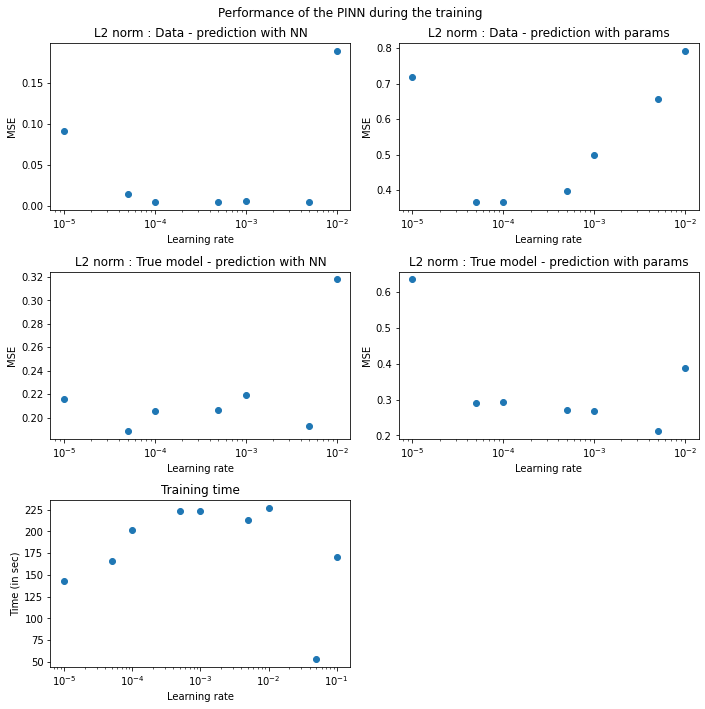

In [18]:
time_full_train_in_sec = []
MSE_data_NNpred = []
MSE_data_modelNNparams = []
MSE_true_NNpred = []
MSE_true_modelNNparams = []
for i in range(len(list_lr)):
    time_full_train_in_sec.append(all_perf_lr[i]["Training time (in sec):"])
    MSE_data_NNpred.append(all_perf_lr[i]["MSE data-prediction NN:"])
    MSE_data_modelNNparams.append(all_perf_lr[i]["MSE data-prediction model with fitted parameters:"])
    MSE_true_NNpred.append(all_perf_lr[i]["MSE true model-prediction NN:"])
    MSE_true_modelNNparams.append(all_perf_lr[i]["MSE true model-prediction model with fitted parameters:"])

plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1).xaxis.set_major_locator(MaxNLocator(integer=True))
plt.scatter(list_lr, MSE_data_NNpred) ; plt.xlabel("Learning rate") ; plt.ylabel("MSE") ; plt.title("L2 norm : Data - prediction with NN") ; plt.xscale('log')
plt.subplot(3, 2, 2).xaxis.set_major_locator(MaxNLocator(integer=True))
plt.scatter(list_lr, MSE_data_modelNNparams) ; plt.xlabel("Learning rate") ; plt.ylabel("MSE") ; plt.title("L2 norm : Data - prediction with params") ; plt.xscale('log')
plt.subplot(3, 2, 3).xaxis.set_major_locator(MaxNLocator(integer=True))
plt.scatter(list_lr, MSE_true_NNpred) ; plt.xlabel("Learning rate") ; plt.ylabel("MSE") ; plt.title("L2 norm : True model - prediction with NN") ; plt.xscale('log')
plt.subplot(3, 2, 4).xaxis.set_major_locator(MaxNLocator(integer=True))
plt.scatter(list_lr, MSE_true_modelNNparams) ; plt.xlabel("Learning rate") ; plt.ylabel("MSE") ; plt.title("L2 norm : True model - prediction with params") ; plt.xscale('log')
plt.subplot(3, 2, 5).xaxis.set_major_locator(MaxNLocator(integer=True))
plt.scatter(list_lr, time_full_train_in_sec) ; plt.xlabel("Learning rate") ; plt.ylabel("Time (in sec)") ; plt.title("Training time") ; plt.xscale('log')
plt.suptitle("Performance of the PINN during the training")
plt.tight_layout()
plt.savefig(directory_path + "/0-performance_summary.jpg")
plt.show()